In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

from pandas import read_csv
from sklearn.feature_selection import SelectKBest #ANOVA
from sklearn.feature_selection import f_classif #ANOVA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 1. Data Gathering

In [2]:
df=pd.read_csv("onlinefraud.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [3]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### Column names and description

In [4]:
# step: represents a unit of time where 1 step equals 1 hour
# type: type of online transaction
# amount: the amount of the transaction
# nameOrig: customer starting the transaction
# oldbalanceOrg: balance before the transaction
# newbalanceOrig: balance after the transaction
# nameDest: recipient of the transaction
# oldbalanceDest: initial balance of recipient before the transaction
# newbalanceDest: the new balance of recipient after the transaction
# isFraud: fraud transaction

# Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Here two features have object datatype we have to typecaste this features

In [6]:
df.isna().sum() ## There are no missing values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.duplicated().value_counts()

False    6362620
dtype: int64

### In our dataset null values and duplicates are not present 

In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# 3. EDA

### 1.Type

In [9]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [10]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

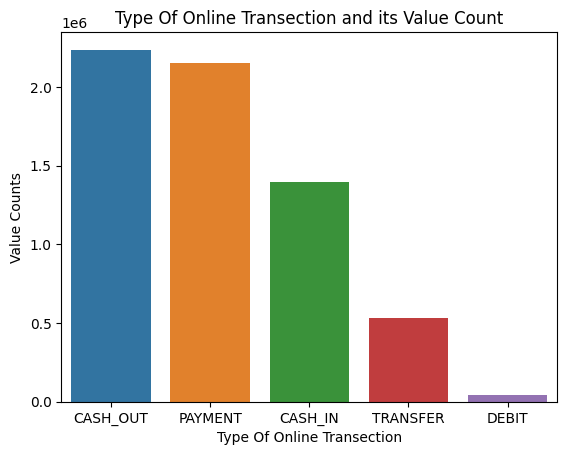

In [11]:
sns.barplot(x = df.type.value_counts().index, y = df.type.value_counts().values)
plt.xlabel("Type Of Online Transection")
plt.ylabel("Value Counts")
plt.title("Type Of Online Transection and its Value Count")
plt.show()

### Here from boxplot of type of online transaction we observe that CASH_OUT and PAYMENT takes more data so we conclude that the most of fraud will b e in this two types

### 2.Amount

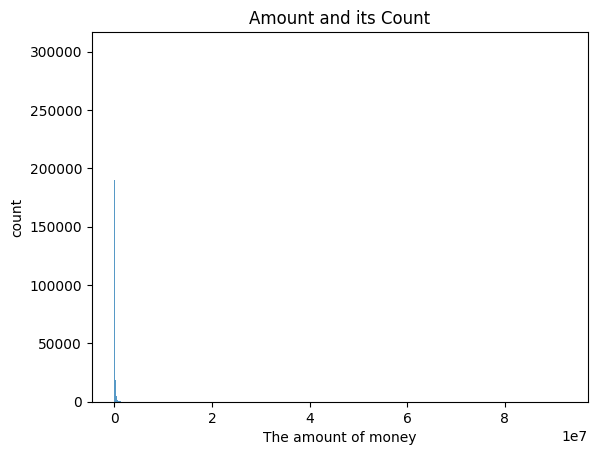

In [12]:
sns.histplot(df["amount"])
plt.xlabel('The amount of money')
plt.ylabel("count")
plt.title("Amount and its Count")
plt.show()

In [13]:
# 100 largest amounts in column

df.nlargest(100,columns="amount")

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3686583,276,TRANSFER,92445516.64,C1715283297,0.0,0.0,C439737079,9.595980e+03,9.245511e+07,0,0
4060598,300,TRANSFER,73823490.36,C2127282686,0.0,0.0,C753026640,9.362401e+07,1.674475e+08,0,0
4146397,303,TRANSFER,71172480.42,C2044643633,0.0,0.0,C84111522,1.134615e+08,1.846340e+08,0,0
3946920,286,TRANSFER,69886731.30,C1425667947,0.0,0.0,C167875008,1.515387e+08,2.214254e+08,0,0
3911956,284,TRANSFER,69337316.27,C1584456031,0.0,0.0,C1472140329,1.130072e+08,1.823446e+08,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4149527,303,TRANSFER,42183808.56,C1835360608,266493.9,0.0,C8271807,6.780774e+07,1.099915e+08,0,0
4053230,300,TRANSFER,41988600.77,C55478598,0.0,0.0,C60911281,6.457754e+07,1.407997e+08,0,0
3750972,279,TRANSFER,41963708.15,C1237771660,0.0,0.0,C947086614,8.409592e+07,1.260596e+08,0,0
4061245,300,TRANSFER,41818052.20,C1011191693,0.0,0.0,C880754345,9.606096e+07,1.378790e+08,0,0


In [14]:
from collections import Counter

Counter(df.nlargest(100, 'amount').type)

Counter({'TRANSFER': 100})

### Here we observe that from largest 100 amounts there are 45 Cah_out ,22 Cash_in and 33 Transfer values here CASH_OUT values are more

In [15]:
# Now we have to check is there any fraud in transection of lagrest 100 amount


fraud = df.nlargest(100, 'amount').isFraud
# fraud
counter = 0
if 1 in fraud.values:                      #1:Fraud 0:No Fraud
    counter +=1
counter

0

### In largest 100 amount of money no fraud is detected ,we can conclude that the largest amount of money the transaction nearly has more security than small amounts of money

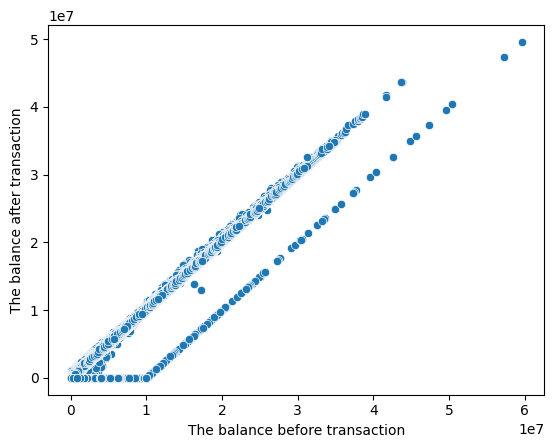

In [16]:
sns.scatterplot(x = df.oldbalanceOrg, y = df.newbalanceOrig)
plt.xlabel('The balance before transaction')
plt.ylabel('The balance after transaction')
plt.show()

In [17]:
df[['oldbalanceOrg', 'newbalanceOrig']].corr()

,oldbalanceOrg,newbalanceOrig
oldbalanceOrg,1.000000,0.998803
newbalanceOrig,0.998803,1.000000


### strong positive correlation between the balance between the balance before transaction and balance after transaction and that's mean
    
### The higher the account balance => The higher the transfer balance

In [18]:
# get top 10 most frequent client distination id

df['nameDest'].value_counts()[:11]

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
C977993101      96
Name: nameDest, dtype: int64

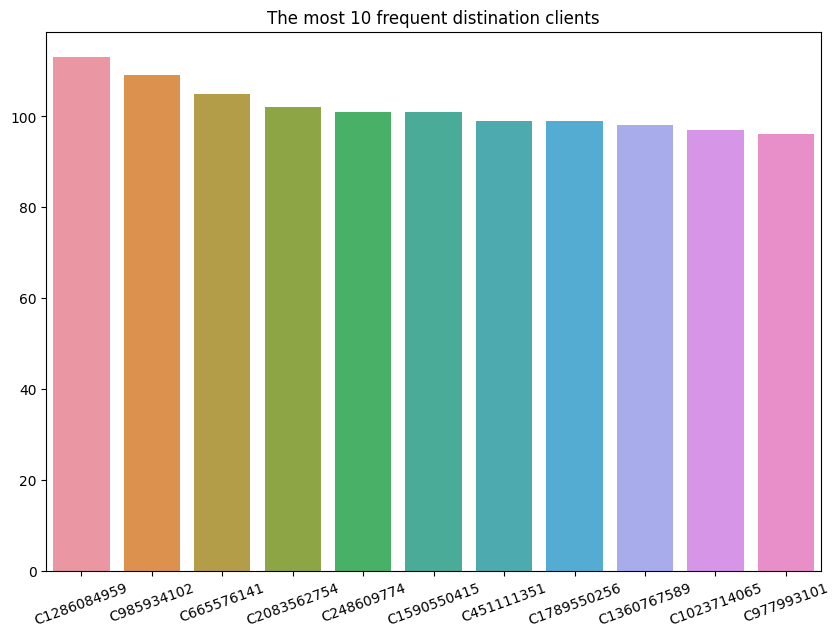

In [19]:
plt.figure(figsize = [10, 7])
sns.barplot(x = df['nameDest'].value_counts()[:11].index, y = df['nameDest'].value_counts()[:11].values)
plt.title('The most 10 frequent distination clients')
plt.xticks(rotation = 20)
plt.show()

### Here We can see that the nameDest or client_id C1286084959 has largest amount of money transfer 

In [20]:
#for the distination client id C1286084959 let's see the largest amount of money transfer and is fraud or not

df[df["nameDest"] == 'C1286084959']

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
93,1,TRANSFER,583848.46,C1839168128,0.00,0.00,C1286084959,667778.00,2107778.11,0,0
367,1,TRANSFER,176334.26,C169880779,45136.00,0.00,C1286084959,1251626.46,2107778.11,0,0
388,1,CASH_OUT,373068.26,C1047934137,20034.00,0.00,C1286084959,1427960.73,2107778.11,0,0
471,1,CASH_IN,403418.39,C848097505,3834666.95,4238085.34,C1286084959,1801028.99,2107778.11,0,0
642,1,CASH_IN,222126.95,C870322840,6688712.64,6910839.59,C1286084959,1397610.60,2107778.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4810092,346,CASH_OUT,84205.39,C86576996,0.00,0.00,C1286084959,61680519.75,61764725.14,0,0
4832993,347,CASH_OUT,235564.75,C1068656420,0.00,0.00,C1286084959,61764725.14,62000289.89,0,0
5566959,393,CASH_IN,119568.31,C1878371174,8348248.96,8467817.28,C1286084959,62000289.89,61880721.58,0,0
5596560,394,CASH_OUT,381887.53,C1789981744,50447.00,0.00,C1286084959,61880721.58,62262609.11,0,0


In [21]:
df[df["nameDest"] == 'C1286084959'].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,113.000000,1.130000e+02,1.130000e+02,1.130000e+02,1.130000e+02,1.130000e+02,113.0,113.0
mean,48.654867,6.852119e+05,1.528629e+06,1.578053e+06,1.302417e+07,1.429012e+07,0.0,0.0
std,100.229627,2.616135e+06,2.634386e+06,2.717605e+06,1.468275e+07,1.511047e+07,0.0,0.0
min,1.000000,2.373110e+03,0.000000e+00,0.000000e+00,6.677780e+05,1.378570e+06,0.0,0.0
25%,3.000000,1.196750e+05,0.000000e+00,0.000000e+00,2.539946e+06,2.107778e+06,0.0,0.0
50%,8.000000,2.467958e+05,2.812300e+04,0.000000e+00,1.101671e+07,1.295976e+07,0.0,0.0
75%,17.000000,4.250524e+05,2.395084e+06,2.562312e+06,1.773507e+07,1.877455e+07,0.0,0.0
max,401.000000,2.130032e+07,1.092285e+07,1.104356e+07,6.226261e+07,6.245186e+07,0.0,0.0


In [22]:
df[(df["nameDest"] == 'C1286084959')&(df["isFraud"]==1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


### 'C1286084959' client has 91  Transections but fraud not detected

In [23]:
df[df["isFraud"]==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [24]:
df[df["isFlaggedFraud"]==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [25]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

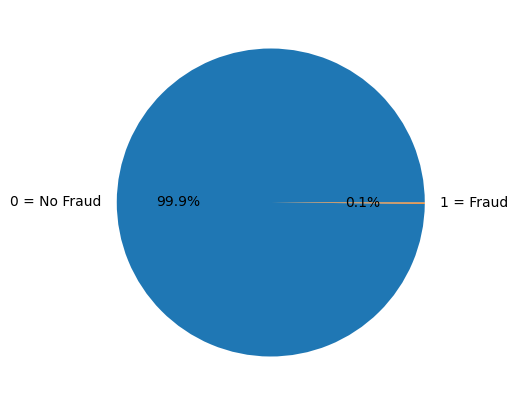

In [26]:
fig = plt.figure(figsize =(5, 5))
plt.pie(df.isFraud.value_counts(),labels= ["0 = No Fraud","1 = Fraud"],autopct='%1.1f%%')
plt.show()

### We observed that the Fraud data is very very small 0.1% and Non fraud data is 99.9% i.e Our Target variable is Highly imbalanced

## Encoding the Categorical columns

In [27]:
df["type"] = df["type"].replace({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})

In [28]:
df.corr()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.012627,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
type,0.012627,1.000000,0.198987,0.260418,0.270669,0.066255,0.079111,0.016171,0.003144
amount,0.022373,0.198987,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,0.260418,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,0.270669,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.066255,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.079111,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.016171,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.003144,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


<AxesSubplot:>

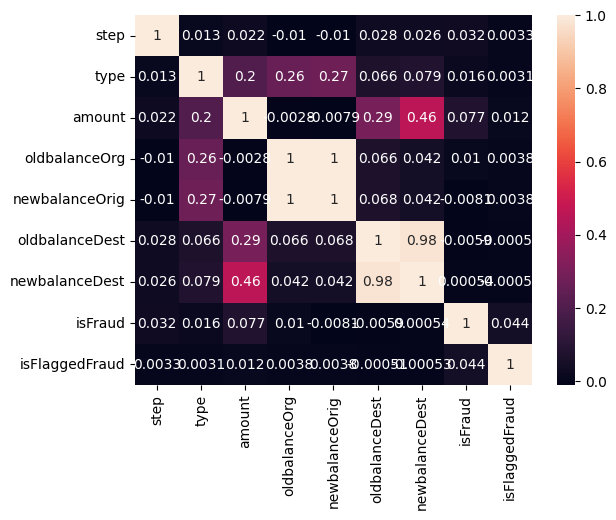

In [29]:
sns.heatmap(df.corr(),annot= True)

# 4.Feature Selection

In [30]:
df.drop(["step","nameOrig","nameDest"],axis=1,inplace=True)

### Here step,nameOrig and nameDest doesn't  give any information so we dropped that columns

In [31]:
x = df.drop(['isFraud',"isFlaggedFraud"], axis = 1)
y = df['isFraud']

### ANOVA Test

In [32]:
from sklearn.feature_selection import f_classif
f_val, p_val = f_classif(x, y)
df_anova = pd.DataFrame({'F-Val':f_val , 'P-Val': np.around(p_val,2)}, index=x.columns)
df_anova

,F-Val,P-Val
type,1664.354165,0.00
amount,37640.657952,0.00
oldbalanceOrg,656.131724,0.00
newbalanceOrig,422.458368,0.00
oldbalanceDest,220.386451,0.00
newbalanceDest,1.823504,0.18


In [33]:
df_anova.sort_values(by = ['F-Val'], ascending=True)

df_Ho = df_anova[(df_anova['F-Val'] < 300)]
df_Ho.index

Index(['oldbalanceDest', 'newbalanceDest'], dtype='object')

In [34]:
x=x.drop(df_Ho.index,axis=1)
x

,type,amount,oldbalanceOrg,newbalanceOrig
0,2,9839.64,170136.00,160296.36
1,2,1864.28,21249.00,19384.72
2,4,181.00,181.00,0.00
3,1,181.00,181.00,0.00
4,2,11668.14,41554.00,29885.86
...,...,...,...,...
6362615,1,339682.13,339682.13,0.00
6362616,4,6311409.28,6311409.28,0.00
6362617,1,6311409.28,6311409.28,0.00
6362618,4,850002.52,850002.52,0.00


### Here we perform ANOVA test and we take Features with highest F_Values 

# 5.Feature Engineering

### Outlier Handling

### Boxplot of features before capping outliers

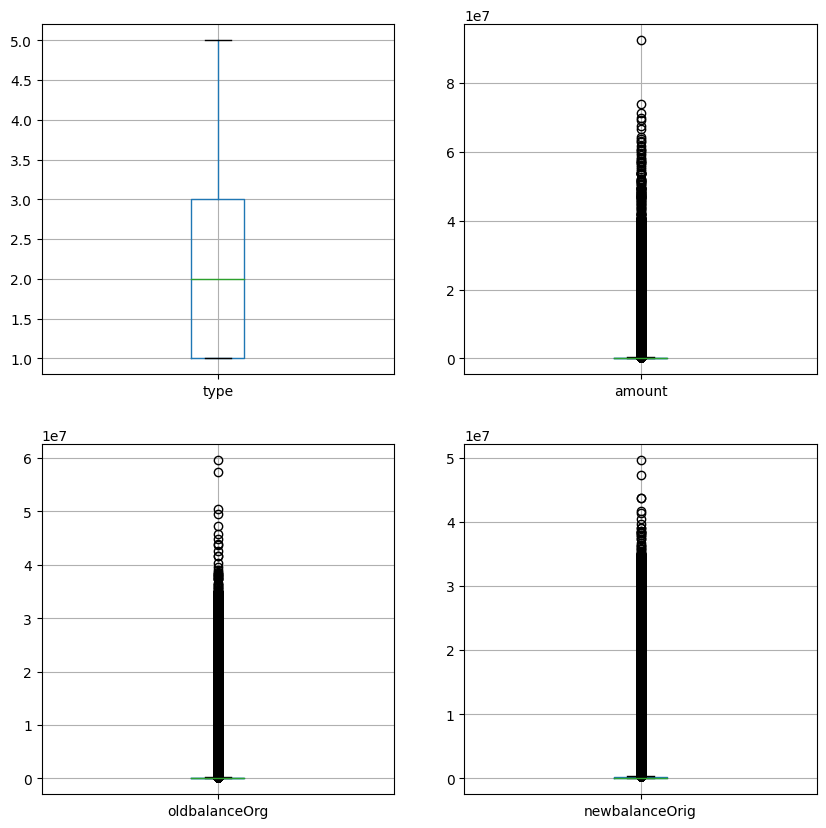

In [35]:
i = 1
plt.figure(figsize=(10,10))
for col in x.columns:
    plt.subplot(2,2,i)
    x[[col]].boxplot()
    i+=1
plt.show()

In [36]:
def impute_outliers(col):
    for col in x.columns:
        print("capping the ",col)
        if (((x[col].dtype)=='float64') | ((x[col].dtype)=='int64')):
            q1 = x[col].quantile(0.25)
            q2 = x[col].quantile(0.5)
            q3 = x[col].quantile(0.75)

            print('Q1 == ', q1)
            print('Q2 == ', q2)
            print('Q3 == ', q3)

            iqr = q3 - q1
            print('IQR == ', iqr)

            upper_tail = q3 + 1.5*iqr 
            lower_tail = q1 - 1.5*iqr

            print('Upper Tail :', upper_tail)
            print('Lower Tail :', lower_tail)

            x[col].loc[x[col] > upper_tail] = upper_tail # We replaced value greater than upper tail by upper tail
            x[col].loc[x[col] < lower_tail] = lower_tail # We replaced value lower than lower tail by lower tail
            print("**"*40)
impute_outliers(x[col])

capping the  type
Q1 ==  1.0
Q2 ==  2.0
Q3 ==  3.0
IQR ==  2.0
Upper Tail : 6.0
Lower Tail : -2.0
********************************************************************************
capping the  amount
Q1 ==  13389.57
Q2 ==  74871.94
Q3 ==  208721.4775
IQR ==  195331.9075
Upper Tail : 501719.33875
Lower Tail : -279608.29125
********************************************************************************
capping the  oldbalanceOrg
Q1 ==  0.0
Q2 ==  14208.0
Q3 ==  107315.175
IQR ==  107315.175
Upper Tail : 268287.9375
Lower Tail : -160972.7625
********************************************************************************
capping the  newbalanceOrig
Q1 ==  0.0
Q2 ==  0.0
Q3 ==  144258.41
IQR ==  144258.41
Upper Tail : 360646.025
Lower Tail : -216387.615
********************************************************************************


### Boxplot of features after capping outliers

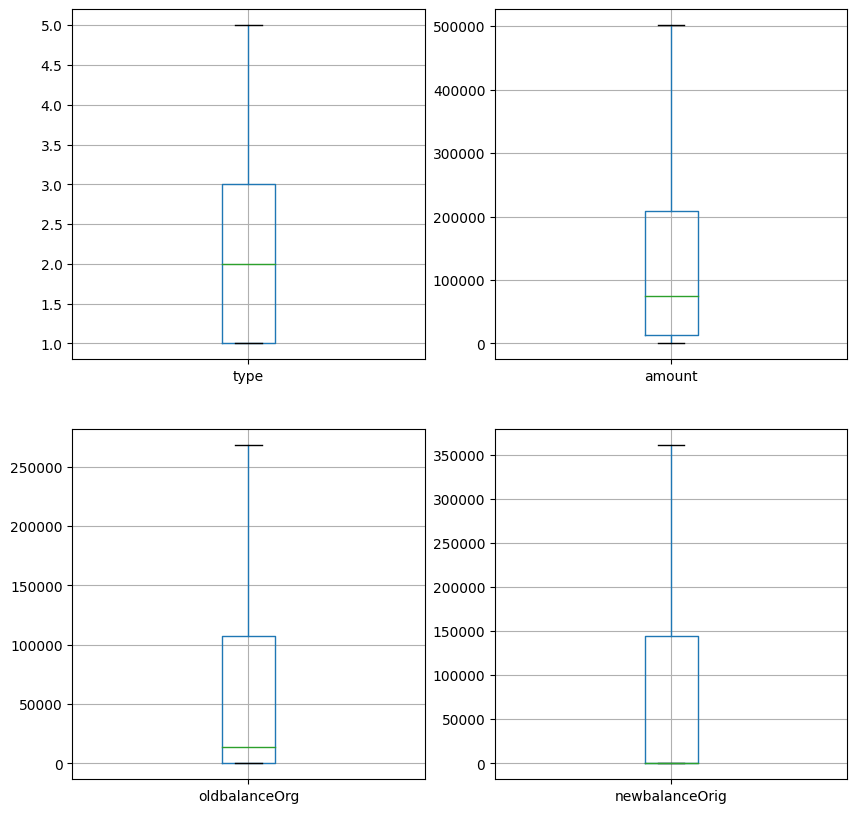

In [37]:
i = 1
plt.figure(figsize=(10,10))
for col in x.columns:
    plt.subplot(2,2,i)
    x[[col]].boxplot()
    i+=1
plt.show()

# 5. Model Building

### Model Training

In [38]:
x = df.drop(['isFraud',"isFlaggedFraud"], axis = 1)
y = df['isFraud']
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [39]:
smote_os = SMOTE(sampling_strategy=0.85)
x_df,y_df = smote_os.fit_resample(x_train,y_train)
print(y.value_counts())
print(y_df.value_counts())

0    6354407
1       8213
Name: isFraud, dtype: int64
0    4765769
1    4050903
Name: isFraud, dtype: int64


## 1. Logistic Regression

In [40]:
logistic_clf = LogisticRegression()
logistic_clf.fit(x_df, y_df)

LogisticRegression()

In [41]:
def evaluation(string, model, ind_var, act):
    print(string.center(50,'*'))
    
    pred = model.predict(ind_var)
    cnf_matrix = confusion_matrix(act, pred)
    print('\nConfusion Matrix :\n', cnf_matrix)
    
    accuracy = accuracy_score(act, pred)
    print('\nAccuracy :', accuracy)
    
    clf_report = classification_report(act,pred)
    print('\nClassification Report :\n', clf_report)
    
evaluation('Test Data Evaluation', logistic_clf, x_test, y_test)
print('##'*30)
evaluation('Train Data Evaluation', logistic_clf, x_df, y_df)

***************Test Data Evaluation***************

Confusion Matrix :
 [[1354132  234506]
 [     42    1975]]

Accuracy : 0.8525462781055603

Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.85      0.92   1588638
           1       0.01      0.98      0.02      2017

    accuracy                           0.85   1590655
   macro avg       0.50      0.92      0.47   1590655
weighted avg       1.00      0.85      0.92   1590655

############################################################
**************Train Data Evaluation***************

Confusion Matrix :
 [[4062089  703680]
 [  63022 3987881]]

Accuracy : 0.9130395233031239

Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.85      0.91   4765769
           1       0.85      0.98      0.91   4050903

    accuracy                           0.91   8816672
   macro avg       0.92      0.92      0.91   8816672
weig

AUC Score = 0.9800869512566119


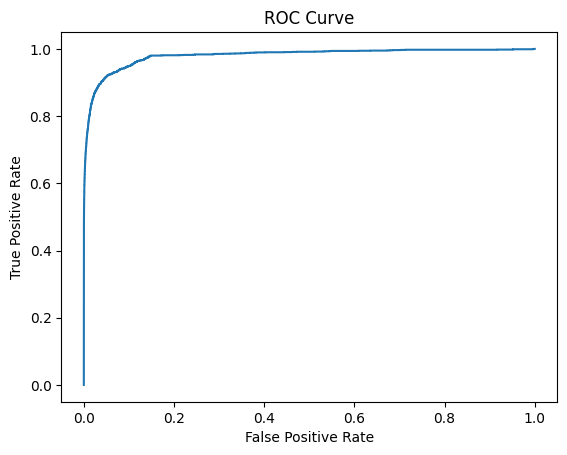

In [42]:
y_pred_proba = logistic_clf.predict_proba(x_test)
y_pred_proba
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba[:,1])
thresh
plt.title('ROC Curve')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
print('AUC Score =',auc_score)

## 2. Random Forest

In [44]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=34)
rf_clf.fit(x_df,y_df)

KeyboardInterrupt: 

In [ ]:
evaluation('Test Data Evaluation', rf_clf, x_test, y_test)
print('*#'*30)
evaluation('Train Data Evaluation', rf_clf, x_df, y_df)

## Hyperparameters Tuning

In [ ]:
rf_model = RandomForestClassifier(random_state=34,max_samples=0.75,
                                 bootstrap=True, oob_score=True, n_jobs=-1)

hyp = {'n_estimators':np.arange(20,150),
    'criterion':['gini','entropy'],
    'max_depth': np.arange(3,10),
    'min_samples_split':np.arange(5,15),
    'min_samples_leaf':np.arange(3,10),}

rscv_rf_model = RandomizedSearchCV(rf_model, hyp, cv = 3)
rscv_rf_model.fit(x_df,y_df)
rscv_rf_model.best_estimator_

In [ ]:
rf_clf_model = RandomForestClassifier(criterion='entropy', max_depth=9, max_samples=0.75,
                       min_samples_leaf=4, min_samples_split=12,
                       n_estimators=25, n_jobs=-1, oob_score=True,
                       random_state=34)
rf_clf_model.fit(x_df,y_df)

In [ ]:
evaluation('Test Data Evaluation', rf_clf_model, x_test, y_test)
print('##'*30)
evaluation('Train Data Evaluation', rf_clf_model, x_df, y_df)

## 3. DecisionTree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=20)
dt_clf.fit(x_df,y_df)

In [ ]:
evaluation('Test Data Evaluation', dt_clf, x_test, y_test)
print('*#'*30)
evaluation('Train Data Evaluation', dt_clf, x_df, y_df)

## Hyperparameters Tuning

In [ ]:
dt_model = DecisionTreeClassifier(random_state=20)

hyperparamters = {'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':np.arange(3,10),
    'min_samples_split':np.arange(5,20) ,
    'min_samples_leaf':np.arange(3,20)}

rscv_dt_model = RandomizedSearchCV(dt_model, hyperparamters, cv = 5)
rscv_dt_model.fit(x_df, y_df)
rscv_dt_model.best_estimator_

In [ ]:
rscv_dt_model.best_params_

In [ ]:
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=9, min_samples_leaf=8,
                       min_samples_split=12, random_state=20,
                       splitter='best')
dt_clf.fit(x_df,y_df)

In [ ]:
evaluation('Test Data Evaluation', dt_clf, x_test, y_test)
print('*#'*30)
evaluation('Train Data Evaluation', dt_clf, x_df, y_df)

## 4. AdaBoost Classifier

In [ ]:
adb_clf = AdaBoostClassifier(learning_rate=0.5, random_state=20)
adb_clf.fit(x_df, y_df)

In [ ]:
evaluation('Test Data Evaluation', adb_clf, x_test, y_test)
print('##'*30)
evaluation('Train Data Evaluation', adb_clf, x_df, y_df)

## Hyperparameters Tuning

In [ ]:
adb_model = AdaBoostClassifier(random_state=20)
hyp_grid = {'n_estimators': np.arange(10,50),
           'learning_rate':np.arange(0.01, 2, 0.01)}

rscv_adb_clf = RandomizedSearchCV(adb_model, hyp_grid, cv=7, random_state= 10)
rscv_adb_clf.fit(x_df,y_df)
rscv_adb_clf.best_estimator_

In [ ]:
rscv_adb_clf.best_params_

In [ ]:
adb_clf = AdaBoostClassifier(learning_rate=1.21, n_estimators=39, random_state=20)
adb_clf.fit(x_df, y_df)

In [ ]:
evaluation('Test Data Evaluation', adb_clf, x_test, y_test)
print('##'*30)
evaluation('Train Data Evaluation', adb_clf, x_df, y_df)

### ROC-AUC Curve for all Models

In [ ]:
from sklearn import metrics
#set up plotting area
plt.figure().clf()
plt.figure(figsize=(10,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#fit logistic regression model and plot ROC curve
y_pred =  logistic_clf.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
y_pred = rf_clf_model.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Decision tree model and plot ROC curve
y_pred =  dt_clf.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Decision tree, AUC="+str(auc))

#fit Adaboost model and plot ROC curve
y_pred =  adb_clf.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Adaboost, AUC="+str(auc))

#add legend
plt.legend()

In [ ]:
# if  model.predict([[2,170136.0,160296.36,9839.64]])[0] == 0:
#     print('not Fraud')
# else: print('is Fraud')